# Allan Calibration IMU

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Load Imu data from a GY85 device

With each line : (time, ax, ay, az, gx, gy, gz, gt)

In [46]:
def load_imu(imu_data_file, b_filter=False):
    # we cut the several data at the start of the data, as it may went wrong
    imu_data = np.loadtxt(imu_data_file)
    
    if b_filter:
        imu_data = imu_data[1000:,:]
        # filter abnormal data
        # In the raw data, I found abnormal data in gx and gy
        # I don't think these are the device problem
        # Remark: this should fit for your konwn data
        average = np.average(imu_data[:,4:6], axis=0)
        threshold = 0.7
        derivation = np.abs(imu_data[:,4:6] - average)
        max_deri = np.max(derivation, axis=0)
        flag = derivation < max_deri*threshold
        flag = np.bitwise_and.reduce(flag, axis=1)

        #print("before: ", imu_data.shape)
        imu_data = imu_data[flag, :]
        #print("after: ", imu_data.shape)
    
    data_gyr = imu_data[:,4:]
    data_acc = imu_data[:,1:4]
    timestamps = imu_data[:,0]
    dt = np.average(timestamps[1:] - timestamps[:-1])
    
    return imu_data, data_gyr, data_acc, dt
    
imu_data_file = "imu_data.txt"
imu_data, data_gyr, data_acc, dt = load_imu(imu_data_file)

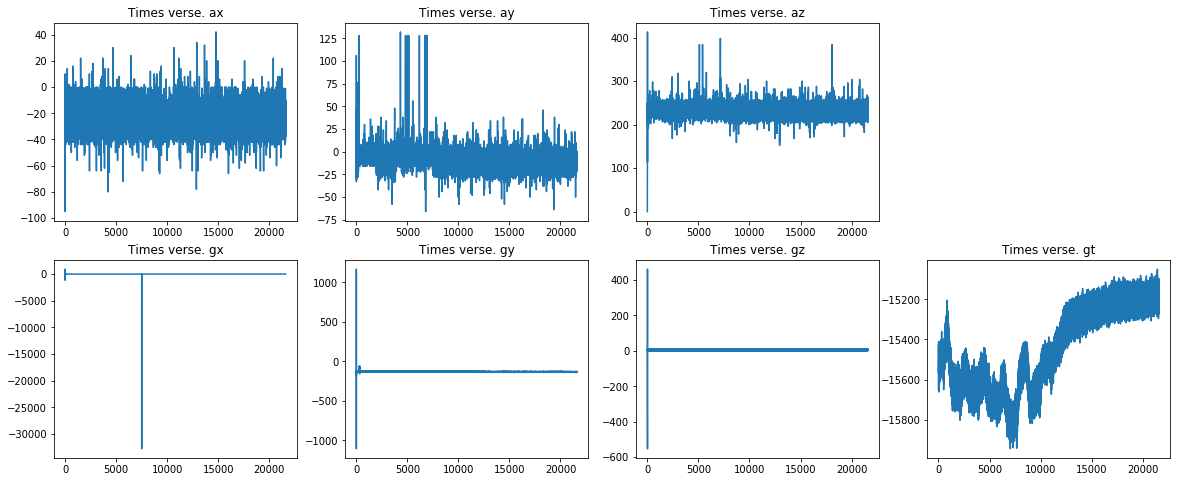

In [47]:
def plot_raw_data(imu_data):
    names = ["time", "ax", "ay", "az", "gx", "gy", "gz", "gt"]
    id_plot = [1,2,3,5,6,7,8]
    t = imu_data[:,0]
    plt.figure(figsize=(20,8))
    for i in range(7):
        plt.subplot(2, 4, id_plot[i]); plt.plot(t, imu_data[:,(i+1)], label=names[i+1])
        plt.title("Times verse. " + names[i+1])
    
plot_raw_data(imu_data)

# 1. Gyroscope

[Reference Matlab](https://www.mathworks.com/help/nav/ug/inertial-sensor-noise-analysis-using-allan-variance.html), [Another Reference](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3306435/#c8), example [kalibr_allan](https://github.com/rpng/kalibr_allan) .

Parameter | YAML element | Symbol | Units
--- | --- | --- | ---
Gyroscope "white noise" | `gyroscope_noise_density` | <img src="https://latex.codecogs.com/svg.latex?{%5Csigma_g}"> | <img src="https://latex.codecogs.com/svg.latex?{%5Cfrac%7Brad%7D%7Bs%7D%5Cfrac%7B1%7D%7B%5Csqrt%7BHz%7D%7D}">
Accelerometer "white noise" | `accelerometer_noise_density` | <img src="https://latex.codecogs.com/svg.latex?{%5Csigma_a}"> | <img src="https://latex.codecogs.com/svg.latex?{%5Cfrac%7Bm%7D%7Bs^2%7D%5Cfrac%7B1%7D%7B%5Csqrt%7BHz%7D%7D}">
Gyroscope "random walk" | `gyroscope_random_walk` | <img src="https://latex.codecogs.com/svg.latex?{%5Csigma_b_g}"> | <img src="https://latex.codecogs.com/svg.latex?{%5Cfrac%7Brad%7D%7Bs^2%7D%5Cfrac%7B1%7D%7B%5Csqrt%7BHz%7D%7D}">
Accelerometer "random walk" | `accelerometer_random_walk` | <img src="https://latex.codecogs.com/svg.latex?{%5Csigma_b_a}"> | <img src="https://latex.codecogs.com/svg.latex?{%5Cfrac%7Bm%7D%7Bs^3%7D%5Cfrac%7B1%7D%7B%5Csqrt%7BHz%7D%7D}">

The gyroscope measurement is modeled as:

$$
\Omega(t) = \Omega_{Ideal}(t) + \mathbf{Bias}_{N}(t) + \mathbf{Bias}_{B}(t) + \mathbf{Bias}_{K}(t)
$$

The three noise parameters N (angle random walk), K (rate random walk), and B (bias instability) are estimated using data logged from a stationary gyroscope.

## 1.1 Allan Variance

#### Accumulate angle for each element

$$
\theta(t) = \int^{t}\Omega(t')dt'
$$

#### Calculate the Allan variance

$$
\sigma^{2}(\tau) = \frac{1}{2\tau^{2}}<(\theta_{k+2m}-2\theta_{k+m}+\theta_{k})^{2}>
$$

$$
\sigma^{2}(\tau) = \frac{1}{2\tau^{2}(L-2m)}\sum_{k=1}^{L-2m}(\theta_{k+2m}-2\theta_{k+m}+\theta_{k})^{2}
$$

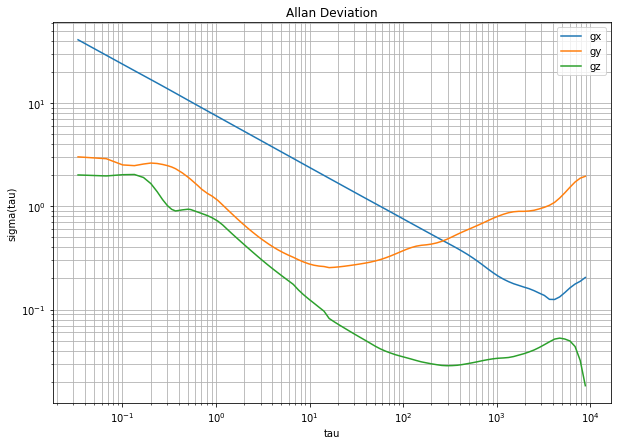

In [48]:
def allan_variance(data_gyr, idx, dt, num_m = 100):
    data_gyr_x = np.cumsum(data_gyr[:,idx])*dt
    #plt.figure();plt.plot(data_gyr_x);
    L = data_gyr_x.shape[0]
    max_m = np.power(2, np.floor(np.log2(L/2)))
    m = np.logspace(np.log10(1), np.log10(max_m), num=num_m)
    m = np.ceil(m) # m must be an integer.
    m = np.unique(m) # Remove duplicates.
    
    tau = m * dt
    average = np.zeros(m.shape[0])
    for i in range(m.shape[0]):
        mi = int(m[i])
        tmp = data_gyr_x[2*mi:L] - 2*data_gyr_x[mi:L-mi] + data_gyr_x[0:L-2*mi]
        average[i] = np.sum(tmp*tmp)
    average = average/(2*(L-2*m)*tau*tau)
    return tau, np.sqrt(average)

def allan_variance_all_plot(data_gyr, dt, num_m = 100):
    plt.figure(figsize=(10,7))
    labels = ["gx", 'gy', 'gz']
    for i in range(3):
        tau, a_dev = allan_variance(data_gyr, i, dt)
        plt.loglog(tau, a_dev, label=labels[i])
        plt.title('Allan Deviation')
        plt.xlabel('tau');
        plt.ylabel('sigma(tau)')
    plt.grid(True, which="both", ls="-")
    plt.legend()
    
allan_variance_all_plot(data_gyr, dt)

## 1.2 Noise Parametes

To obtain the noise parameters for the gyroscope, use the following relationship between the Allan variance and the two-sided power spectral density (PSD) of the noise parameters in the original data set :

$$
\sigma^{2}(\tau) = 4\int_{0}^{\infty}S_{\Omega}(f)\frac{\sin^{4}(\pi f\tau)}{(\pi f\tau)^{2}}df
$$

From the above equation, the Allan variance is proportional to the total noise power of the gyroscope when passed through a filter with a transfer function of $sin^4(x)/(x)^2$. This transfer function arises from the operations done to create and operate on the clusters.

#### Angle Random Walk

The angle random walk is characterized by the white noise spectrum of the gyroscope output. The PSD is represented by:

$$
S_\Omega(f) = N^2
$$

where, N = angle random walk coefficient. Substituting into the original PSD equation and performing integration yields:

$$\sigma^2(\tau) = \frac{N^2}{\tau}$$

The above equation is a line with a slope of -1/2 when plotted on a log-log plot of $\sigma(\tau)$ versus $\tau$. The value of N can be read directly off of this line at $\tau = 1$.

In [49]:
def allan_calibration_angle_random_walk(tau, adev):
    # Find the index where the slope of the log-scaled Allan deviation is equal
    # to the slope specified.
    slope = -0.5;
    logtau = np.log10(tau);
    logadev = np.log10(adev);
    dlogadev = np.diff(logadev) / np.diff(logtau);
    i = np.argmin(np.abs(dlogadev - slope));

    # Find the y-intercept of the line.
    b = logadev[i] - slope*logtau[i];

    # Determine the angle random walk coefficient from the line.
    logN = slope*np.log(1) + b;
    N = np.power(10, logN)
    return N, i


#### Rate Random Walk
The rate random walk is characterized by the red noise (Brownian noise) spectrum of the gyroscope output. The PSD is represented by:

$$S_\Omega(f) = (\frac{K}{2\pi})^2\frac{1}{f^2}$$

where

K = rate random walk coefficient

Substituting into the original PSD equation and performing integration yields:

$$\sigma^2(\tau) = \frac{K^2\tau}{3}$$

The above equation is a line with a slope of 1/2 when plotted on a log-log plot of $\sigma(\tau)$ versus $\tau$. The value of K can be read directly off of this line at $\tau = 3$.

In [50]:
def allan_calibration_rate_random_walk(tau, adev):
    # Find the index where the slope of the log-scaled Allan deviation is equal
    # to the slope specified.
    slope = 0.5;
    logtau = np.log10(tau);
    logadev = np.log10(adev);
    dlogadev = np.diff(logadev) / np.diff(logtau);
    i = np.argmin(np.abs(dlogadev - slope));

    # Find the y-intercept of the line.
    b = logadev[i] - slope*logtau[i];

    # Determine the rate random walk coefficient from the line.
    logK = slope*np.log10(3) + b;
    K = np.power(10, logK)
    return K, i

#### Bias Instability
The bias instability is characterized by the pink noise (flicker noise) spectrum of the gyroscope output. The PSD is represented by:

$$S_{\Omega}(f) = \left\{\begin{array}{lr}
(\frac{B^2}{2\pi})\frac{1}{f} : f \leq f_0\\0: f > f_0
\end{array}\right.$$

where, B = bias instability coefficient, $f_0$ = cut-off frequency.
Substituting into the original PSD equation and performing integration yields:

$$\sigma^2(\tau) = \frac{2B^2}{\pi}[\ln{2} + -\frac{sin^3x}{2x^2}(sinx + 4xcosx) + Ci(2x) - Ci(4x)]$$

where, $x = \pi f_0\tau$, Ci = cosine-integral function.
When $\tau$ is much longer than the inverse of the cutoff frequency, the PSD equation is:

$$\sigma^2(\tau) = \frac{2B^2}{\pi}\ln{2}$$

The above equation is a line with a slope of 0 when plotted on a log-log plot of $\sigma(\tau)$ versus $\tau$. The value of B can be read directly off of this line with a scaling of $\sqrt{\frac{2\ln{2}}{\pi}} \approx 0.664$.

In [199]:
# https://ch.mathworks.com/matlabcentral/answers/344786-generation-of-1-f-noise-using-matlab
def simulate_flicker(flicker_B, length=int(1e6)):
    from scipy import signal
    fv = np.arange(0,20, 1)
    a = 1/(1+2*fv)
    b = signal.firls(43, fv, a)
    ns = np.random.randint(length, size=(length))
    invfn = signal.filtfilt(b, 1, ns)
    invfn = (invfn - np.mean(invfn))/length
    return invfn

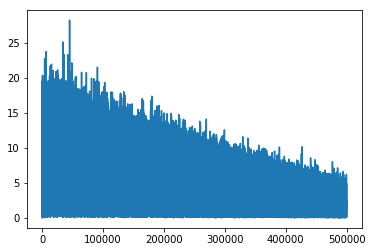

In [202]:
invfn = simulate_flicker(1)
fft_sim_data = np.fft.fft(invfn)[:int(invfn.shape[0]/2)]
plt.figure()
plt.plot(abs(fft_sim_data))

In [51]:
def allan_calibration_bias_instability(tau, adev):
    # Find the index where the slope of the log-scaled Allan deviation is equal
    # to the slope specified.
    slope = 0;
    logtau = np.log10(tau);
    logadev = np.log10(adev);
    dlogadev = np.diff(logadev) / np.diff(logtau);
    i = np.argmin(np.abs(dlogadev - slope));

    # Find the y-intercept of the line.
    b = logadev[i] - slope*logtau[i];

    # Determine the bias instability coefficient from the line.
    scfB = np.sqrt(2*np.log(2)/np.pi);
    logB = b - np.log10(scfB);
    B = np.power(10, logB)
    return B, scfB, tau[i]

In [52]:
def allan_calibration(data_gyr, idx, dt, num_m=100):
    tau, adev = allan_variance(data_gyr, idx, dt, num_m)
    
    N, _ = allan_calibration_angle_random_walk(tau, adev)
    K, _ = allan_calibration_rate_random_walk(tau, adev)
    B, scfB, tauB = allan_calibration_bias_instability(tau, adev)
    # Plot the results.
    tauN = 1;
    lineN = N / np.sqrt(tau);
    tauK = 3;
    lineK = K * np.sqrt(tau/3);
    lineB = B * scfB * np.ones(tau.shape);

    tauParams = [tauN, tauK, tauB];
    params = [N, K, scfB*B];
    plt.loglog(tau, adev, tau, lineN, tau, lineK, tau, lineB, '--', tauParams, params, 'o')
    plt.title('Allan Deviation, N:'+str(N)[0:5]+', K:'+str(K)[0:5]+', B:'+str(B)[0:5])
    plt.xlabel('$\tau$')
    plt.ylabel('$\sigma(\tau)$')
    plt.legend(['$\sigma$', '$\sigma_N$', '$\sigma_K$', '$\sigma_B$'])
    labels = ['$\sigma$= '+str(N)[0:5]+'rad/$s^1$sqrt(Hz)', '$\sigma_b$= '+str(K)[0:5]+'rad/$s^2$sqrt(Hz)', '0.664B']
    for i in range(3):
        plt.text(tauParams[i], params[i], labels[i])
    plt.grid(True, which="both", ls="-")

def allan_calibration_all(data_gyr, dt):
    plt.figure(figsize=(20,5))
    for i in range(data_gyr.shape[1]):
        ax = plt.subplot(1, data_gyr.shape[1], (i+1))
        allan_calibration(data_gyr, i, dt)
        ax.axis('equal')

Allan Calibration Acceleration


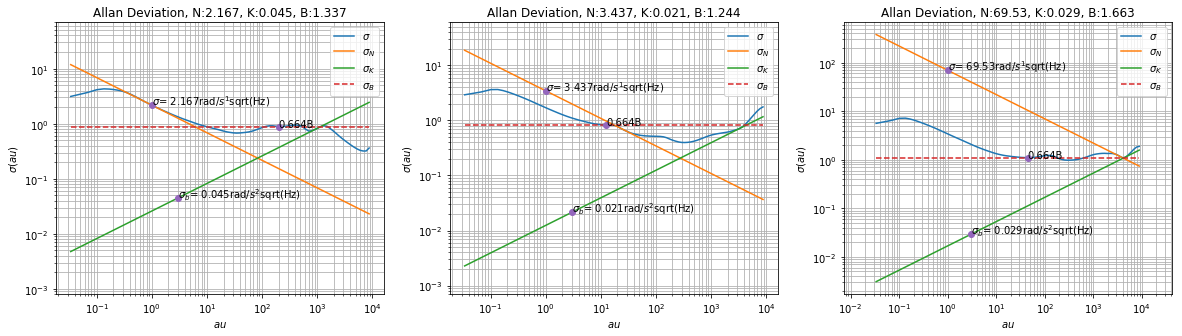

In [54]:
print("Allan Calibration Acceleration")
allan_calibration_all(data_acc[:,0:3], dt)

Allan Calibration Gyroscope


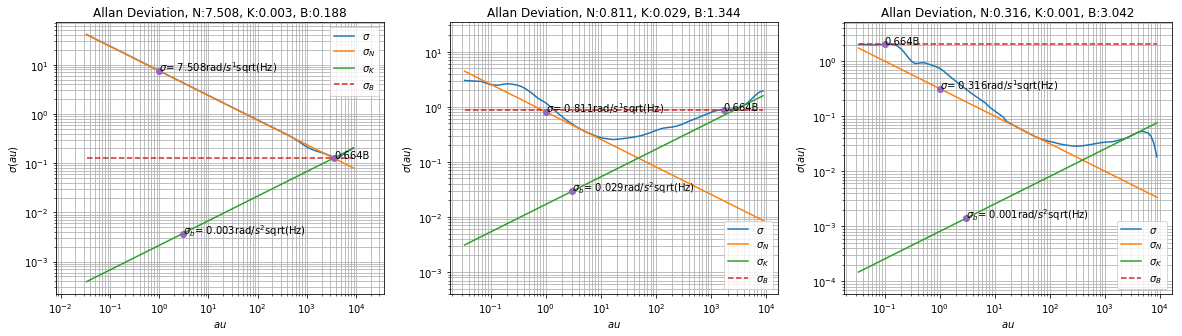

In [53]:
print("Allan Calibration Gyroscope")
allan_calibration_all(data_gyr[:,0:3], dt)

### Simulate the data

In [212]:
def simulate_imu(noise_N, random_walk_K, bias, length=1e6 ,freq=30):
    #length = int(time * freq)
    dt = 1/freq
    sim_data = np.zeros(length)
    int_random_work = 0
    for i in range(length):
        int_random_work += random_walk_K * 2 * (np.random.rand()-0.5) * dt
        sim_data[i] = 2*(np.random.rand()-0.5)*noise_N + int_random_work + bias
    return sim_data.reshape((-1,1))

In [228]:
def compare_sim(data_test, dt, title=""):
    bias = np.mean(data_acc)
    tau, a_dev = allan_variance(data_test.reshape([-1,1]), 0, dt)
    N, id_n = allan_calibration_angle_random_walk(tau, a_dev)
    K, id_k = allan_calibration_rate_random_walk(tau, a_dev)
    B, scfB, tauB = allan_calibration_bias_instability(tau, a_dev)

    # Plot the results.
    #tauN = 1;
    #lineN = N / np.sqrt(tau);
    #tauK = 3;
    #lineK = K * np.sqrt(tau/3);
    #lineB = B * scfB * np.ones(tau.shape);

    length = data_acc.shape[0]
    sim_flicker = simulate_flicker(10*B, length).reshape((-1,1))
    sim_test = simulate_imu(10*N, 10*K, bias, length=length, freq=1/dt) + sim_flicker

    #plt.figure(figsize=(20,7))
    #plt.subplot(121); plt.plot(sim_test[:,0]); plt.title("Simulation")
    #plt.subplot(122); plt.plot(data_gyr[:,test_idx]);plt.title("Real")

    #plt.figure(figsize=(20,17))
    tau_s, a_dev_s = allan_variance(sim_test, 0, dt)
    #tauParams = [tauN, tauK, tauB];
    #params = [N, a_dev[id_k], scfB*B];
    #plt.loglog(tau, lineN, tau, lineK, tau, lineB, '--', tauParams, params, 'o')
    plt.loglog(tau_s, a_dev_s, label="simulation")
    plt.loglog(tau, a_dev, label="real")
    plt.title('Allan Deviation ' + title)
    plt.xlabel('tau');
    plt.ylabel('sigma(tau)')
    plt.grid(True, which="both", ls="-")
    plt.legend()

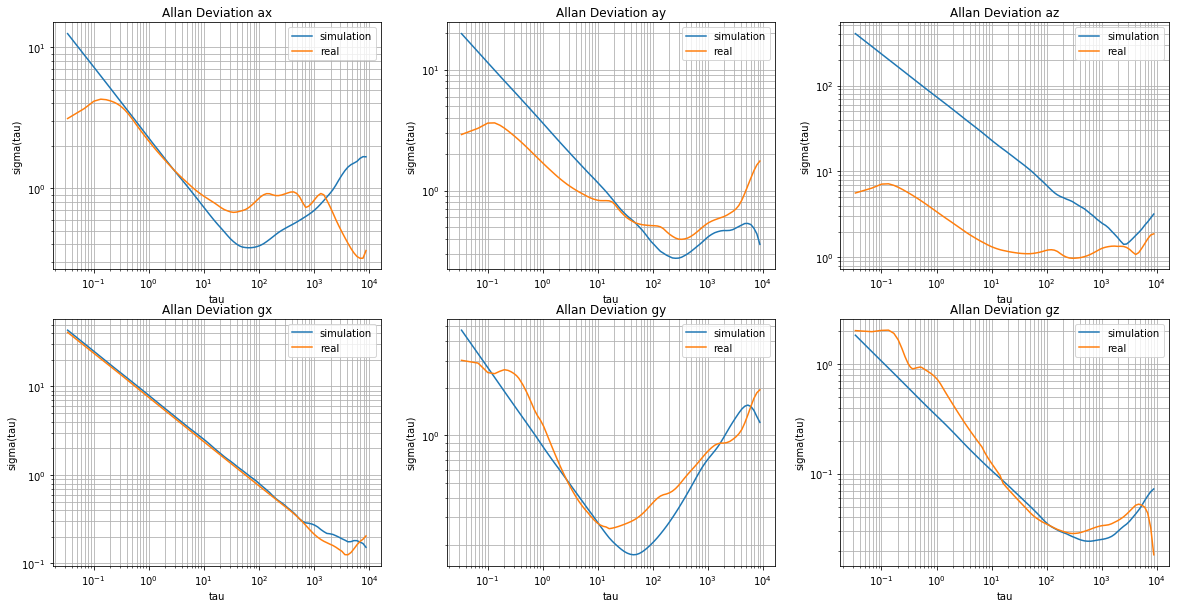

In [219]:
plt.figure(figsize=(20,10))
titles = ["ax", "ay", "az", "gx", "gy", "gz"]
for i in range(3):
    ax = plt.subplot(2, 3, (i+1))
    compare_sim(data_acc[:,i], dt, titles[i])
    ax = plt.subplot(2, 3, (i+4))
    compare_sim(data_gyr[:,i], dt, titles[i+3])